In [2]:
import os  ,sys , os.path, random, math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from shutil import copyfile
import shutil
%matplotlib inline 


In [26]:
#!/usr/local/bin/python


class Pollutant:
    # maintains the current polutant concentration, historical concentration
    def __init__(self,Ratio):
        self.ConversionRatio=Ratio
        self.Concentration=[] #mg/m3
        self.Concentration_Occ = []
        self.Conc=0.0
    def GetPPM(self):
        return self.Conc/self.ConversionRatio
    def SetNew(self,val):
        self.Conc=val
        self.Concentration.append(self.GetPPM())

        
class EnergyPlusModel:
    def __init__(self):
        self.TimeStep = 4
        self.heatingEnergy = 0
        self.coolingEnergy = 0
        self.fanEnergy = 0
        self.EPInstall = 'C:/EnergyPlusV8-8-0_Oring/'
        self.EPWeatherfolder='C:/EnergyPlusV8-3-0/WeatherData/'
        self.IDFfolder='Z:/Dropbox/CERC2.0/EnergyPlusOneZoneModel/'
        
    
    def excuteEnergyPlusmodel(self, IDFname, Weathername):
        self.weatherfile=self.EPWeatherfolder+Weathername+'.epw'
        self.outputfolder=self.IDFfolder+'Output'
        self.IDFfile=self.IDFfolder+IDFname+'.idf'
        self.Csvfile=self.IDFfolder+IDFname + CZ +'.csv'
        self.tablefile=self.IDFfolder+IDFname + CZ +'tbl.csv'
        command_call_EP=self.EPInstall + 'energyplus -w '+self.weatherfile+' -d '+self.outputfolder+' '+self.IDFfile
        os.system(command_call_EP)
        
        output_eso=self.outputfolder+'/eplusout.eso'
        my_file = Path(output_eso)
        if my_file.is_file():
            copyfile(output_eso, "eplusout.eso")
        command_call_ESO = self.IDFfolder+'ReadVarsESO'
        os.system(command_call_ESO)
        shutil.move("eplusout.csv", self.Csvfile)
        shutil.move(self.outputfolder+'/eplustbl.csv', self.tablefile)
        
    def readtable(self):
        fp = open(self.tablefile)
        lines=fp.readlines()
        self.heatingEnergy=float(lines[49][14:18])
        self.coolingEnergy=float(lines[50][9:13])
        self.fanEnergy=float(lines[55][6:10])  
        
        
class SingleZoneModel:
    
    def __init__(self, materialamount):
        self.Volume=1132.67 #+268.08 #m3
        self.TimeStepInSeconds=2*60 #s
        self.AirCleaner1=AirCleaner(materialamount) 
        self.AirCleaner2=AirCleaner(materialamount) 
        self.AirCleaner3=AirCleaner(materialamount)
        self.CO2_with_cleaning=Pollutant(775.0/400.0)
        self.CO2_without_cleaning=Pollutant(775.0/400.0)
        self.CO2_with_cleaning_rg=Pollutant(775.0/400.0)
        self.Occupancy= []
        self.CO2fromEP=[]
        #self.CO2fromBM=[]
        self.Time=[]
        self.Occupancy=[]
        self.TotalVent=[]
        self.Cout= 775 #mg/m3
        self.ConversionRatio= 775.0/400.0
        self.densityofCO2 = 1.9 #1.95#1.98#1.98 #kg/m3
        self.CO2genVol = 3.82E-8 * 130  #m3/s-person
        self.CO2EmissionRate = 3.82E-8 *130*self.densityofCO2*1000000; #mg/s per person (m3/s-W} * kg/m3)
        #self.CO2EmissionRate = 3.82E-8 *130*1000000; #mg/s per person (m3/s-W} * kg/m3)
        self.densityofAir=1.2 # kg/m3 
        self.deplete = 0
   
        
    def ConvertTime(self,DateTimeStr):
        if DateTimeStr[8:10] == '24':
            DateTimeStr = DateTimeStr[0:8] + '00' + DateTimeStr[10:]
        return DateTimeStr
    
    def ExtractTimestepData(self,line):
        self.Infil_val=line['ZONE1:Zone Infiltration Mass Flow Rate [kg/s](TimeStep)']
        self.Flush_Vent=line['ZONE1:Zone Ventilation Mass Flow Rate [kg/s](TimeStep)']
        self.Vent_val=line['AIR LOOP - 1:Air System Outdoor Air Mass Flow Rate [kg/s](TimeStep)']
        self.Occupan_val=line['ZONE1 PEOPLE:People Occupant Count [](TimeStep)']
        self.EPCO2=line['ZONE1:Zone Air CO2 Concentration [ppm](TimeStep)']
        self.densityofAir=line['RETURN AIR OUTLETNODE:System Node Current Density [kg/m3](TimeStep)']
        self.densityofOutsideAir=line['Environment:Site Outdoor Air Density [kg/m3](TimeStep)']
        
    def SimulateMassBalance(self, data):
        SimulationDuration= len(data)/30 #h
        i=0
        maxsteps=int((SimulationDuration*60*60)/self.TimeStepInSeconds)
        self.AirCleaner2.Default=0
        self.AirCleaner1.RegenFlag=False
        self.pollutant_initial = data['ZONE1:Zone Air CO2 Concentration [ppm](TimeStep)'][0]
        
        #CO2t_1 =680 *775/400  #mg/m3
        self.CO2_with_cleaning.Conc=self.pollutant_initial *775/400 #mg/m3
        self.CO2_without_cleaning.Conc=self.pollutant_initial *775/400
        self.CO2_with_cleaning_rg.Conc=self.pollutant_initial *775/400
            
        for eachTimestep in data.index:
            #self.CurrentTime=self.ConvertTime(eachTimestep)
            self.CurrentTime = eachTimestep
            i+=1
            if i>maxsteps: break
            line=data.loc[eachTimestep]
            
            self.ExtractTimestepData(line)
            self.Occupancy.append(self.Occupan_val)
            
            #CO2t_1=self.CalcTimeStepCO2(CO2t_1,self.AirCleaner1)
            new_conc=self.CalcTimeStepConcentration(self.CO2_with_cleaning.Conc,self.AirCleaner1)
            self.CO2_with_cleaning.SetNew(new_conc)
            
            
            new_conc=self.CalcTimeStepConcentration(self.CO2_without_cleaning.Conc,self.AirCleaner2)
            self.CO2_without_cleaning.SetNew(new_conc)
            
            new_conc=self.CalcTimeStepConcentration(self.CO2_with_cleaning_rg.Conc,self.AirCleaner3)
            self.CO2_with_cleaning_rg.SetNew(new_conc)
            
            if self.AirCleaner1.RegenFlag:
                self.AirCleaner1.AirCleaner_Regen(pd.to_datetime(self.CurrentTime,format="%m-%d-%Y %H:%M%p") ,self.TimeStepInSeconds) #maybe save it as this
            
            if self.AirCleaner3.RegenFlag:
                self.AirCleaner3.AirCleaner_Regen(pd.to_datetime(self.CurrentTime,format="%m-%d-%Y %H:%M%p") ,self.TimeStepInSeconds) #maybe save it as this
 

            #self.AirCleanerCapacity.append(self.AirCleaner1.Capacity)
            self.CO2fromEP.append(self.EPCO2)
            self.Time.append(self.CurrentTime)
            self.TotalVent.append(self.VentAirChangeRateinS*3600+self.InfilAirChangeRateinS*3600)
 
        self.meanCO2_BM_Noclean = np.mean([a*b/b for a,b in zip(self.CO2_without_cleaning.Concentration,(self.Occupancy)) \
                                           if b!=0])

        self.meanCO2_BM_clean = np.mean([a*b/b for a,b in zip(self.CO2_with_cleaning.Concentration,(self.Occupancy)) \
                                         if b!=0])

        self.meanCO2_BM_clean_Reg = np.mean([a*b/b for a,b in zip(self.CO2_with_cleaning_rg.Concentration,(self.Occupancy)) \
                                             if b!=0])   
    
        NormVent = (self.TotalVent-min(self.TotalVent))/(max(self.TotalVent)-min(self.TotalVent))
        NormOccupy= (self.Occupancy-min(self.Occupancy))/(max(self.Occupancy)-min(self.Occupancy))
        Curve = pd.DataFrame(self.CO2fromEP,index=self.Time)
        ACHCurve= pd.DataFrame(NormVent,index=self.Time)
        Curve.index = pd.to_datetime(Curve.index,format="%m-%d-%Y %H:%M%p") 
        
        
        Curve["CO2fromBM"]=self.CO2_with_cleaning.Concentration
        Curve["BM_CO2_nAC"]=self.CO2_without_cleaning.Concentration
        Curve["CO2fromBM_rg"]=self.CO2_with_cleaning_rg.Concentration
        Curve.columns = ['EnergyPlus', 'Model_Cleaning','Model_WithoutCleaning', 'Model_Cleaning_RG'] 
        
        #Just first three days for ploting
        Curve = Curve[: 2159]
             
        ACHCurve.columns = ['ACH (Norm.)']
        ACHCurve["AirCleaningOp"]=self.AirCleaner1.AirCleaningOp
        ACHCurve["AirCleaningCap"]=self.AirCleaner1.AirCleanerCapacity
        ACHCurve["AirCleaningCapRG"]=self.AirCleaner3.AirCleanerCapacity
        ACHCurve["Occup. (Norm.)"]=NormOccupy
        ACHCurve = ACHCurve[: 2159]
        
        self.deplete = len(ACHCurve[(ACHCurve['AirCleaningCapRG'] == 0) & (ACHCurve['Occup. (Norm.)'] != 0)])
        self.minRemain = min(ACHCurve['AirCleaningCapRG'])
     
        pltCO2(Curve, ACHCurve)
        
    
    def CalcTimeStepConcentration(self,Ct_1,AirCleaner):    
        # Calculate the new contaminant concentration in mg/m3 taking into account the mass losses and gains from: 
        # ventialtion, infiltration, occupant emissions, deposition, filtration and cleaning.
        self.TotalAirCleanRate=AirCleaner.GetCurrentCleaningRate(Ct_1)

        TotalVentMass=self.Vent_val+self.Flush_Vent #kg/s
        TotalInfilMass=self.Infil_val
        
        TotalVentVol=TotalVentMass/self.densityofAir #m3/3
        TotalInfilVol=TotalInfilMass/self.densityofAir #m3/3
        
        self.VentAirChangeRateinS=TotalVentVol/self.Volume #1/s
        self.InfilAirChangeRateinS=TotalInfilVol/self.Volume #1/s
        
        
        Mass_gain_from_people=self.CO2EmissionRate * self.Occupan_val * self.TimeStepInSeconds/self.Volume #mg/m3
        
        Mass_lost_to_aircleaner = Ct_1 *  self.TotalAirCleanRate   * self.TimeStepInSeconds
        
        Mass_gain_ventilation= self.Cout  *  self.VentAirChangeRateinS * self.TimeStepInSeconds # mg/m3 * 1/s *s  = mg/m3
        Mass_lost_ventilation = Ct_1 *  self.VentAirChangeRateinS    * self.TimeStepInSeconds 
        
        Mass_gain_infiltration= self.Cout  *  self.InfilAirChangeRateinS * self.TimeStepInSeconds # mg/m3 * 1/s *s  = mg/m3
        Mass_lost_infiltration = Ct_1 *  self.InfilAirChangeRateinS    * self.TimeStepInSeconds 
        
        Ct = Ct_1 + Mass_gain_ventilation  - Mass_lost_ventilation + Mass_gain_infiltration -Mass_lost_infiltration - Mass_lost_to_aircleaner + Mass_gain_from_people
       
        AirCleaner.AirCleaner_sorb(Mass_lost_to_aircleaner*self.Volume) #mg/m3
        AirCleaner.AirCleanerCapacity.append(AirCleaner.Capacity)
        return Ct
    
    
    
       
        
    
class AirCleaner:
    def __init__(self, materialamount):
        self.Default=0.5
        self.CO2CleanerEfficiency = 0.1
        self.AirCleanerMass=0
        self.MassOfSorbent= materialamount #100000 #g should be updated
        self.SorbentRatio=40.0/1000 #mg/g
        self.BreakThroughMass= self.MassOfSorbent*self.SorbentRatio #40 grams per kg
        
        
        self.MechanicalAirChangeRate= 4 #1/h
        self.ConversionRatio= 775.0/400.0
        self.SorbedRegCO2Cap=3
        self.PPMTrigger=600
        self.SorbedCO2Mass=0  #g
        self.AirCleaningOp=[]
        self.AirCleanerCapacity=[]
        self.RegenFlag=True
        self.RegenTime=2 #h
        self.RegenEnergy=0
 
        
    def AirCleaner_sorb(self,SorbedMass):
        if self.SorbedCO2Mass == 0:
            self.Capacity=1
            self.CO2CleanerEfficiency= 1
        else:
            self.Capacity=min (1, 1-(self.SorbedCO2Mass/self.BreakThroughMass))
            self.CO2CleanerEfficiency= 1
            if self.Capacity <0: 
                self.Capacity = 0        
        if self.Capacity<0.2:
            self.CO2CleanerEfficiency= self.Capacity*5
        self.SorbedCO2Mass=self.SorbedCO2Mass+SorbedMass/1000
        if self.SorbedCO2Mass<0:
            self.SorbedCO2Mass=0
               

    def AirCleaner_fractioncleaned(self,CO2_conc):
        self.fraction =0
        AirCleanTrigger= self.PPMTrigger*self.ConversionRatio
        if CO2_conc>AirCleanTrigger:
            self.fraction=self.Default
        self.AirCleaningOp.append(self.fraction)
        
    def AirCleaner_Regen(self,time,TimeStepInSeconds):
        if time.hour==2 or time.hour==3:
            #this should be related to temperature etc.. more than time
            Regensteps=int(self.RegenTime*60*60/TimeStepInSeconds)
            if time.minute==0 and time.hour==2:
                self.RegenMassStep=1000*self.SorbedCO2Mass/Regensteps #mg            
#             if time.minute==0:
#                 print ("starting regen for %s/%s in %s steps" % (time.month, time.day,Regensteps))  
            if self.SorbedCO2Mass>0:
                self.AirCleaner_sorb(-self.RegenMassStep)
                self.RegenEnergy += self.RegenMassStep/1000000 * 0.0036
        #if time 
    def GetCurrentCleaningRate(self,CO2_conc):
        self.AirCleaner_fractioncleaned(CO2_conc)
        return self.fraction*self.CO2CleanerEfficiency* self.MechanicalAirChangeRate/3600



class PlotandTable:
    def __init__(self):
        self.loc = 'Energyplot/'
        self.energytable = [['Heating Energy', 'Cooling Energy', 'Fan Energy', 'Regen Energy']]
        self.CO2table = [['NoClean', 'Clean', 'Regen', 'Eplus_CO2_Base', 'Eplus_CO2_NoVent']]
        
    def plotEnergy(self, TotalEnergy, MeanCO2):
        
        fig=plt.figure(figsize=(5,4))
        ind = np.arange(2)
        width = 0.2
        Heating =np.array([TotalEnergy[0][0],TotalEnergy[1][0]])
        Cooling = np.array([TotalEnergy[0][1],TotalEnergy[1][1]])
        Fan = np.array([TotalEnergy[0][2],TotalEnergy[1][2]])
        Regen = np.array([TotalEnergy[0][-1],TotalEnergy[1][-1]])

        p1 = plt.bar(ind, Heating, width, align="center", color='#00ffff')
        p2 = plt.bar(ind, Cooling, width, align="center",color='#3333ff', bottom=sum([Heating]))
        p3 = plt.bar(ind, Fan, width, align="center", color='#87cefa', bottom=sum([Heating, Cooling]))
        p4 = plt.bar(ind, Regen, width, align="center", color='#d62728', bottom=sum([Heating, Cooling, Fan]))    

        plt.xticks(ind, ['Baseline', 'Air Cleaning'])
        plt.ylabel('HVAC Energy Comsuption, GJ')
        plt.title(CZ)
        plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Heating Energy', 'Cooling Energy', 'Fan Energy', 'Regen Energy'), loc='upper center')
        pdfname = self.loc + CZ[:12] + '.pdf'
        pdfname2 = self.loc + CZ[:12] + '.jpg'
        fig.savefig(pdfname,bbox_inches='tight') 
        fig.savefig(pdfname2,bbox_inches='tight') 
        plt.show()

        self.energytable += TotalEnergy
        self.CO2table += MeanCO2
        
class WriteTable:
    def __init__(self):
        self.loc = 'Energyplot/'
        self.energytableName = ['Heating Energy', 'Cooling Energy', 'Fan Energy', 'Regen Energy']
        self.CO2tableName = ['NoClean', 'Clean', 'Regen', 'Eplus_CO2_Base', 'Eplus_CO2_NoVent']
        
    def tableEnergy(self, energytable, CO2table):          
        #self.energyheaders = energytable.pop(0)
        self.energytabledf = pd.DataFrame(energytable, columns=self.energytableName)
        self.energytabledf.to_csv(self.loc + 'energytable.csv')

        #self.headersCO2 = CO2table.pop(0)
        self.CO2tabledf = pd.DataFrame(CO2table, columns=self.CO2tableName)
        self.CO2tabledf.to_csv(self.loc + 'CO2table.csv')

In [23]:
def pltCO2(Curve, ACHCurve):
    fig=plt.figure(figsize=(5,4))
    plt.plot(Curve.EnergyPlus, 'b', label='EnergyPlus')
    plt.plot(Curve.Model_Cleaning, 'k', label='Model_Cleaning')
    plt.plot(Curve.Model_WithoutCleaning, 'r--', label='Model_WithoutCleaning')
    plt.plot(Curve.Model_Cleaning_RG, 'c', label='Model_Cleaning_RG')
    plt.xticks(rotation=45)
    plt.xlabel("Time",fontsize=12)
    plt.ylabel("CO2 PPM",fontsize=12)
    plt.legend(bbox_to_anchor=(1.74, 1))
    plt.show()
    
    styles2 = ['b-','g','r--','c-','m-']       
    ax=ACHCurve.plot(style=styles2, rot=45,legend=True, ylim = (0, 1.1) )
    ax.set_xlabel("Time",fontsize=12)
    ax.set_ylabel("Capacity/ACH",fontsize=12)

    ax.legend(bbox_to_anchor=(1.5, 1))
    
    
def generatedatetimeindex(data):
    from datetime import datetime
    from datetime import timedelta

    start = datetime(2017,1,1,0,0,0)
    end = datetime(2017,12,31,23,58,0)
    seconds = (end - start).total_seconds()

    step = timedelta(minutes=2)

    datetime = []
    for i in range(0, int(seconds), int(step.total_seconds())):
        datetime.append(start + timedelta(seconds=i))
    datetime = [i.strftime("%m-%d-%Y %H:%M%p") for i in datetime]    
    data, data['Date/Time']= data[:-1], datetime   
    data.rename(columns={list(data)[0]:'Date/Time'}, inplace=True)
    data = data.set_index('Date/Time')    
    return data

def printenergychart():
    MeanCO2.append([SingleZone.meanCO2_BM_Noclean, SingleZone.meanCO2_BM_clean, SingleZone.meanCO2_BM_clean_Reg,\
                 Eplus.meanCO2_Eplus_Base, Eplus.meanCO2_Eplus_NoVent])

    TotalEnergy[0].append(0)
    TotalEnergy[1].append(SingleZone.AirCleaner3.RegenEnergy)
    
    plotModel = PlotandTable()
    plotModel.plotEnergy(TotalEnergy, MeanCO2)

def maeanCO2cal(csvName):
    data_base=pd.read_csv(csvnameBase)   
    data_occ_base=data_base[data_base['ZONE1 PEOPLE:People Occupant Count [](TimeStep)'] !=0]
    meanCO2_Eplus_Base = np.mean(data_occ_base['ZONE1:Zone Air CO2 Concentration [ppm](TimeStep)'])
    return data_base, meanCO2_Eplus_Base

Heating energy is 55.3 GJ, Cooling energy is 14.3 GJ, Fan energy is 82.7 GJ
Heating energy is 32.8 GJ, Cooling energy is 12.9 GJ, Fan energy is 83.0 GJ


C:\Users\Xiwang_LBL\Anaconda2\lib\site-packages\ipykernel\__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


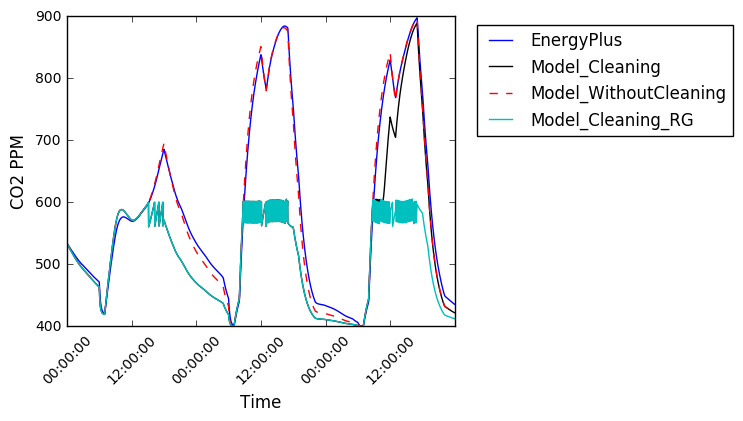

Regen energy is 1.52301155675 GJ, aircleaning is deplet at 0 timestep during occupied hours, and the min remaining is 0.27193614047


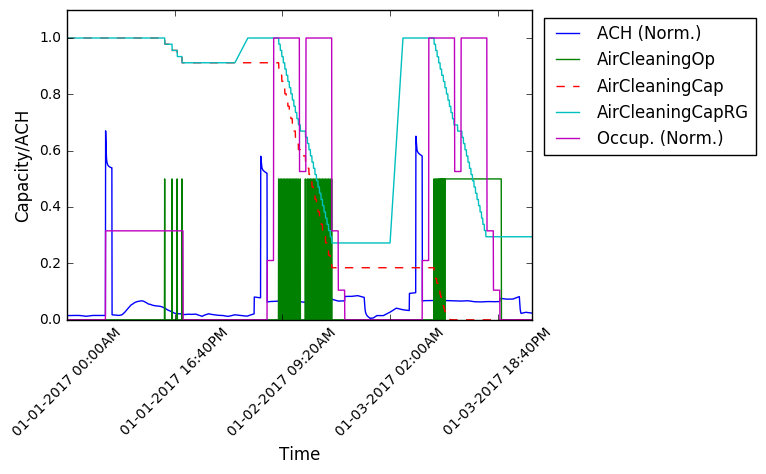

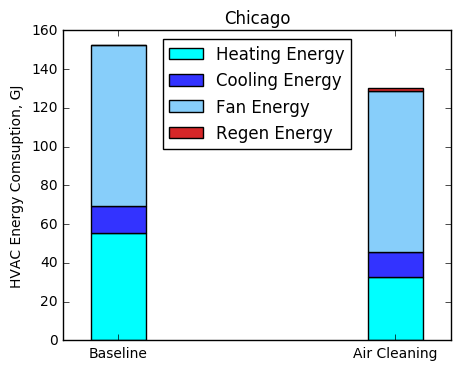

In [30]:
for CZ in ['Chicago']: #['Chicago', 'Miami']:
    IDFs=['SmlOff_BASELINE', 'SmlOff_BASELINE_NoVent']
    TotalEnergy = []
    MeanCO2 = []
    for IDF in IDFs:
        Eplus=EnergyPlusModel()
        Eplus.excuteEnergyPlusmodel(IDF,CZ)
        Eplus.readtable()
        TotalEnergy.append([Eplus.heatingEnergy,Eplus.coolingEnergy,Eplus.fanEnergy])
        print ('Heating energy is %s GJ, Cooling energy is %s GJ, Fan energy is %s GJ' \
           % (Eplus.heatingEnergy, Eplus.coolingEnergy, Eplus.fanEnergy))               
    csvnameBase =Eplus.IDFfolder+IDFs[0] + CZ + '.csv'
    data_base, Eplus.meanCO2_Eplus_Base = maeanCO2cal(csvnameBase)
        
    csvname =Eplus.IDFfolder+IDFs[-1] + CZ + '.csv'   
    data, Eplus.meanCO2_Eplus_NoVent = maeanCO2cal(csvname)     
    data = generatedatetimeindex(data)
        
    SingleZone=SingleZoneModel(100000)#100000
    SingleZone.SimulateMassBalance(data)
    print ('Regen energy is %s GJ, aircleaning is deplet at %s timestep during occupied hours, and the min remaining is %s' \
           % (SingleZone.AirCleaner3.RegenEnergy, SingleZone.deplete, SingleZone.minRemain))    
    printenergychart()    
Tablewirte = WriteTable()   
Tablewirte.tableEnergy(TotalEnergy, MeanCO2)
